In [14]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [15]:
######################################################################
# CartPole ( https://www.gymlibrary.dev/environments/classic_control/cart_pole/ )
#=====================================================================
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset()
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>

In [16]:
# minimum and maximum of [cart_position, cart_velocity, pole_angle, pole_angular_velocity]
env.observation_space 

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [17]:
env.action_space # 0 or 1

Discrete(2)

In [18]:
env.action_space.sample() # random action

0

In [19]:
# take a random action
observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
observation, reward, terminated, truncated, info

(array([ 0.01851902, -0.18902133, -0.02541085,  0.24942426], dtype=float32),
 1.0,
 False,
 False,
 {})

In [20]:
env_screen = env.render() # numpy.ndarray
env_screen.shape

(400, 600, 3)

In [21]:
env_screen

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [22]:
import gym
import numpy as np


# iteration
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset()

total_reward = 0
terminated = False
env_screens = []
while not terminated:
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
    env_screen = env.render() # numpy.ndarray
    env_screens.append(env_screen)
    total_reward += reward

env.close()
total_reward

22.0

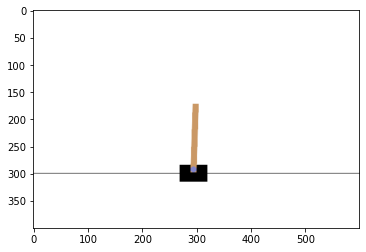

In [23]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

####################################################
# create an animation
#===================================================

fig, ax = plt.subplots()
im = ax.imshow(env_screens[0])

def update(i):
    im.set_data(env_screens[i])
    return (im)

animation = FuncAnimation(fig=fig, func=update, frames=len(env_screens), interval=100)
#plt.show()

# display the animation in the notebook
HTML(animation.to_jshtml())

In [43]:
#################################################################
# compute the expected reward if we always take random actions
#################################################################

import gym
import numpy as np

env = gym.make("CartPole-v1", render_mode="rgb_array")
NUM_EPISODES = 1000
rewards = np.zeros(NUM_EPISODES)

for episode in range(NUM_EPISODES):
    env.reset()
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
    total_reward = reward
    while not terminated:
        # take a random action
        action = env.action_space.sample()
        next_observation, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
    rewards[episode] = total_reward
env.close()

rewards.mean() # expected reward is about 22

22.145

In [25]:
# observation
env.reset()
observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
cart_position, cart_velocity, pole_angle, pole_angular_velocity = observation

# 4 values of a state
print(cart_position, cart_velocity, pole_angle, pole_angular_velocity)

int_arr = (observation > 0).astype('int')
int_arr

-0.014469738 0.16854255 0.014434229 -0.27372316


array([0, 1, 1, 0])

In [78]:
###########################################################
# q learning  
###########################################################

# this script is not powerful but above average. 
# if you are lucky, you get more than 100 reward.
# the performance highly depends on parameters.

import gym
import numpy as np

def run_epoch(q_table=None, training=True):
    # parameters 
    ALPHA = 0.1 # learning rate
    GAMMA = 0.99 # discount factor
    eps = 1 if training == True else 0
    epsilon_decay = 0.99
    
    # there are only 2*2*2*2 states, because we only consider whether values of a state are positive or not
    if q_table is None:
        q_table = np.random.random((2, 2, 2, 2, 2))
        
    NUM_EPISODES = 200
    rewards = np.zeros(NUM_EPISODES)
    env = gym.make("CartPole-v1", render_mode="rgb_array")

    for episode in range(NUM_EPISODES):
        observation, info = env.reset() # initialize
        episode_reward = 0
        terminated = False
        while not terminated:
            is_pos_positive, is_cart_v_positive, is_angle_positive, is_angular_v_positive = (observation > 0).astype('int') 

            # choose an action by epsilon greedy method
            if np.random.random() <= eps:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[is_pos_positive, is_cart_v_positive, is_angle_positive, is_angular_v_positive, :])

            # take an action
            next_observation, reward, terminated, truncated, info = env.step(action)

            # q table update
            if training:
                is_next_pos_positive, is_next_cart_v_positive, is_next_angle_positive, is_next_angular_v_positive = (next_observation > 0).astype('int') 
                max_q = q_table[is_next_pos_positive, is_next_cart_v_positive, is_next_angle_positive, is_next_angular_v_positive,:].max()
                current_q = q_table[is_pos_positive, is_cart_v_positive, is_angle_positive, is_angular_v_positive, action] 
                q_table[is_pos_positive, is_cart_v_positive, is_angle_positive, is_angular_v_positive, action] += ALPHA * (reward + GAMMA * max_q - current_q)

            # prepare next iteration
            observation = next_observation
            episode_reward += reward
            eps *= epsilon_decay

        # record the result
        rewards[episode] = episode_reward

    env.close()
    return rewards.mean(), q_table


####################################################
# run epochs
#===================================================

best_avg_reward = 0
best_q_table = None
for _ in range(100):
    epi_avg, q_table = run_epoch()
    # record the best reward and q_table
    if epi_avg > best_avg_reward:
        best_avg_reward = epi_avg
        best_q_table = q_table
        print(f"new record: episode reward avearage {best_avg_reward}")
print("Done.")

best_avg_reward, best_q_table

new record: episode reward avearage 20.97
new record: episode reward avearage 93.93
new record: episode reward avearage 166.855
new record: episode reward avearage 251.675
Done.


(251.675,
 array([[[[[9.61684512e+01, 1.47435695e+00],
           [2.04281221e+00, 9.61643445e+01]],
 
          [[6.26053189e-03, 9.54560506e+01],
           [1.52061294e+00, 9.36776991e+01]]],
 
 
         [[[9.58522440e+01, 9.99813339e-01],
           [9.36260187e+01, 4.52794995e-01]],
 
          [[9.54600090e+01, 9.30647875e-01],
           [1.51926658e+00, 9.28377108e+01]]]],
 
 
 
        [[[[1.75608335e-01, 7.62715356e+01],
           [9.30021397e+01, 5.01860782e-01]],
 
          [[7.65749397e+01, 2.72972291e-01],
           [5.24779804e-01, 9.47545625e+01]]],
 
 
         [[[8.19731683e+01, 6.24515847e-01],
           [7.13895906e-01, 7.93513986e+01]],
 
          [[9.53139685e+01, 1.36674966e+00],
           [1.67930151e+00, 9.53230547e+01]]]]]))

In [91]:
epi_avg, q_table = run_epoch(best_q_table, training=False)
epi_avg, q_table

(191.365,
 array([[[[[9.61684512e+01, 1.47435695e+00],
           [2.04281221e+00, 9.61643445e+01]],
 
          [[6.26053189e-03, 9.54560506e+01],
           [1.52061294e+00, 9.36776991e+01]]],
 
 
         [[[9.58522440e+01, 9.99813339e-01],
           [9.36260187e+01, 4.52794995e-01]],
 
          [[9.54600090e+01, 9.30647875e-01],
           [1.51926658e+00, 9.28377108e+01]]]],
 
 
 
        [[[[1.75608335e-01, 7.62715356e+01],
           [9.30021397e+01, 5.01860782e-01]],
 
          [[7.65749397e+01, 2.72972291e-01],
           [5.24779804e-01, 9.47545625e+01]]],
 
 
         [[[8.19731683e+01, 6.24515847e-01],
           [7.13895906e-01, 7.93513986e+01]],
 
          [[9.53139685e+01, 1.36674966e+00],
           [1.67930151e+00, 9.53230547e+01]]]]]))